<a href="https://colab.research.google.com/github/maxigaarp/Gestion-De-Datos-en-R/blob/main/R_y_RSQL_en_DATAMINEDUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
system("gdown https://drive.google.com/uc?id=1q089qSqKr7Ak29lUkzKSWjm2pcb_jzX0")
unzip("/content/matriculas_y_notas_anual.zip")

In [ ]:
install.packages("RSQLite")
install.packages("data.table")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’, ‘plogr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [1]:
library(data.table)
library(RSQLite)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [ ]:
system("gdown https://drive.google.com/uc?id=1bxebySwiYquw1B72xi1E_YrELXzDS4cC")


In [ ]:
system("mv /content/Rendimiento2013.csv /content/content/Datos/20210223_Rendimiento_2013.csv")

In [2]:
conn <- dbConnect(RSQLite::SQLite(), "mineduc.db")


Supongamos que queremos ver la cantidad de años que tiene cada alumno registrado a lo largo de los 18 años de datos disponibles en MINEDUC.

Filtrando la información me quedo con una tabla de alumnos con su informacion relevante y otra con los colegios.


# Solo con R

In [ ]:
colenames <- c("RBD","AGNO","NOM_RBD","COD_REG_RBD","NOM_COM_RBD", "COD_DEPE","RURAL_RBD")
alnames <- c("MRUN","AGNO","RBD","COD_ENSE","COD_GRADO","LET_CUR",
                              "GEN_ALU", "FEC_NAC_ALU","COD_COM_ALU", "SIT_FIN_R",
                              "PROM_GRAL", "ASISTENCIA")

colegios=data.frame(matrix(nrow=0,ncol=length(colenames)))
names(colegios)<- colenames

alumnos=data.frame(matrix(nrow=0,ncol=length(alnames)))
names(alumnos)<- alnames

years<-2002:2020
for (i in 1:length(years)) {
  name=gsub("%",years[i],"/content/content/Datos/20210223_Rendimiento_%.csv")
  data=fread(name)
  names(data) <- toupper(names(data))


  coles <- data %>% 
    select(c("RBD","AGNO","NOM_RBD","COD_REG_RBD","NOM_COM_RBD", "COD_DEPE","RURAL_RBD"))%>% 
    distinct()
  
  alus <- data %>%
        select(c("MRUN","AGNO","RBD","COD_ENSE","COD_GRADO","LET_CUR",
                    "GEN_ALU", "FEC_NAC_ALU","COD_COM_ALU", if (years[i]!=2014) "SIT_FIN_R" else "SIT_FINAL_R",
                      "PROM_GRAL", "ASISTENCIA")) %>% 
        distinct()
  names(alus)=alnames

  colegios <- colegios %>%
              rbind(coles)
  alumnos <- alumnos %>%
              rbind(alus)

}


In [ ]:
grados <- alumnos %>%
          group_by(MRUN) %>%
          count(AGNO)

# Cargando bases en SQL


In [5]:
colenames <- c("RBD","AGNO","NOM_RBD","COD_REG_RBD","NOM_COM_RBD", "COD_DEPE","RURAL_RBD")
alnames <- c("MRUN","AGNO","RBD","COD_ENSE","COD_GRADO","LET_CUR",
             "GEN_ALU", "FEC_NAC_ALU","COD_COM_ALU", "SIT_FIN_R",
             "PROM_GRAL", "ASISTENCIA")

years<-2002:2020
for (i in 1:length(years)) {
  name=gsub("%",years[i],"/content/content/Datos/20210223_Rendimiento_%.csv")
  data=fread(name)
  names(data) <- toupper(names(data))


  coles <- data %>% 
    select(colenames)%>% 
    distinct()
  
  alus <- data %>%
        select(c("MRUN","AGNO","RBD","COD_ENSE","COD_GRADO","LET_CUR",
                    "GEN_ALU", "FEC_NAC_ALU","COD_COM_ALU", if (years[i]!=2014) "SIT_FIN_R" else "SIT_FINAL_R",
                      "PROM_GRAL", "ASISTENCIA")) %>% 
        distinct()
        
  names(alus)=alnames

  apnd=if (i==1) FALSE else TRUE

  dbWriteTable(conn , name = "colegios", 
                  value = coles,
                  row.names = FALSE, header = !apnd, sep=',',append=apnd,
                  colClasses='character')

  dbWriteTable(conn , name = "alumnos", 
                  value = alus,
                  row.names = FALSE, header = !apnd, sep=',',append=apnd,
                  colClasses='character')
}

En particular podemos hacer consultas complicadas de manera rapida y sin preocuparnos por si el computador podrá darnos una respuesta antes de acabarse la memoria RAM.

Supongamos que queremos ver si la asistencia influye en el rendimiento, para eso calculamos el promedio de asistencia y rendimiento 

Contar la cantidad de años que un alumno ha estado en el colegio

In [ ]:
dbGetQuery(conn, "
SELECT  MRUN,
        COUNT(AGNO)
FROM alumnos
GROUP BY MRUN;")

MRUN,COUNT(AGNO)
<int>,<int>
NA,6077
3,6
4,6
5,8
17,13
18,13
19,12
20,17
25,13


Analizar los diferentes nombres de los colegios

In [ ]:
dbGetQuery(conn, "
select 
RBD,
NOM_RBD,
COUNT( DISTINCT NOM_RBD) AS NNAMES
from colegios 
GROUP BY RBD
ORDER BY NNAMES;")

RBD,NOM_RBD,NNAMES
<int>,<chr>,<int>
4,LICEO OCTAVIO PALMA PEREZ,1
9,ESCUELA REPUBLICA DE ISRAEL,1
16,ESCUELA REGIMIENTO RANCAGUA,1
22,ESCUELA GABRIELA MISTRAL,1
29,ESCUELA AMERICA,1
33,ESCUELA CARLOS CONDELL DE LA HAZA,1
35,ESCUELA GRAL. MANUEL BAQUEDANO,1
41,ESCUELA VALLE DE CHACA,1
45,COLEGIO ITALIANO SANTA ANA,1


Cantidad de repitencias por grado en los colegios cientifico humanistas

In [ ]:
resp <- dbGetQuery(conn, "
SELECT 
SIT_FIN_R,
COD_ENSE,
COD_GRADO,
COUNT(MRUN) AS REPITENCIAS
FROM alumnos
Where (COD_ENSE==110 OR COD_ENSE==310)
GROUP BY COD_ENSE, COD_GRADO, SIT_FIN_R")

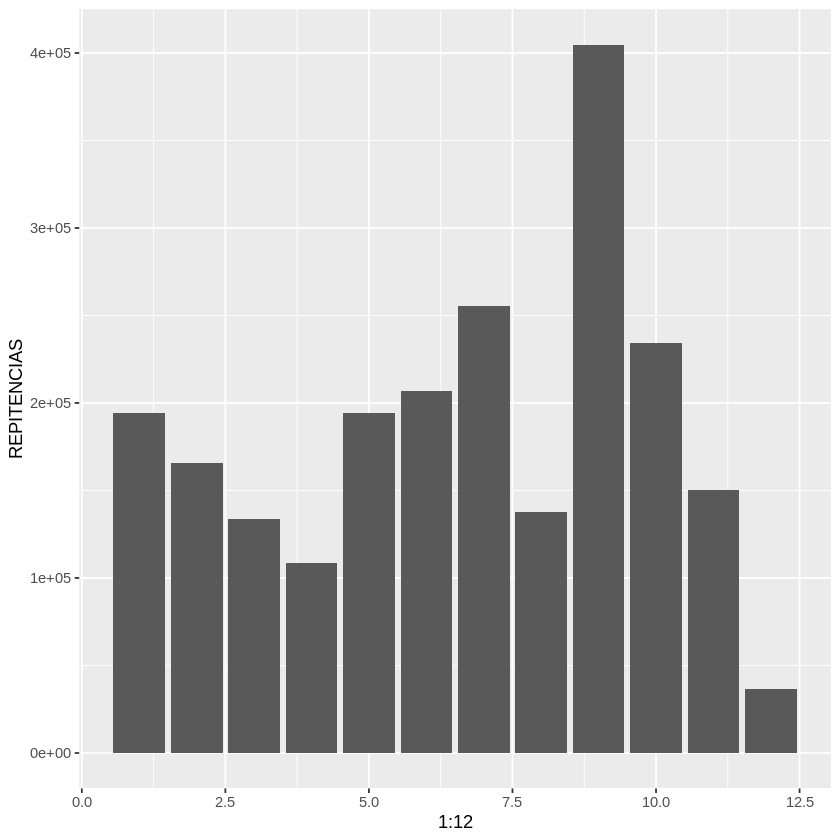

In [ ]:
resp %>% filter(SIT_FIN_R=="R") %>%
        arrange(COD_ENSE,COD_GRADO)%>%
        ggplot(aes(x=1:12,y=REPITENCIAS)) + 
            geom_bar(stat="identity", position="stack")


In [ ]:
resp %>% filter(SIT_FIN_R=="T") %>%
        arrange(COD_ENSE,COD_GRADO)

SIT_FIN_R,COD_ENSE,COD_GRADO,REPITENCIAS
<chr>,<int>,<int>,<int>
T,110,1,298447
T,110,2,236488
T,110,3,221589
T,110,4,189896
T,110,5,200565
T,110,6,185513
T,110,7,195139
T,110,8,155404
T,310,1,185084


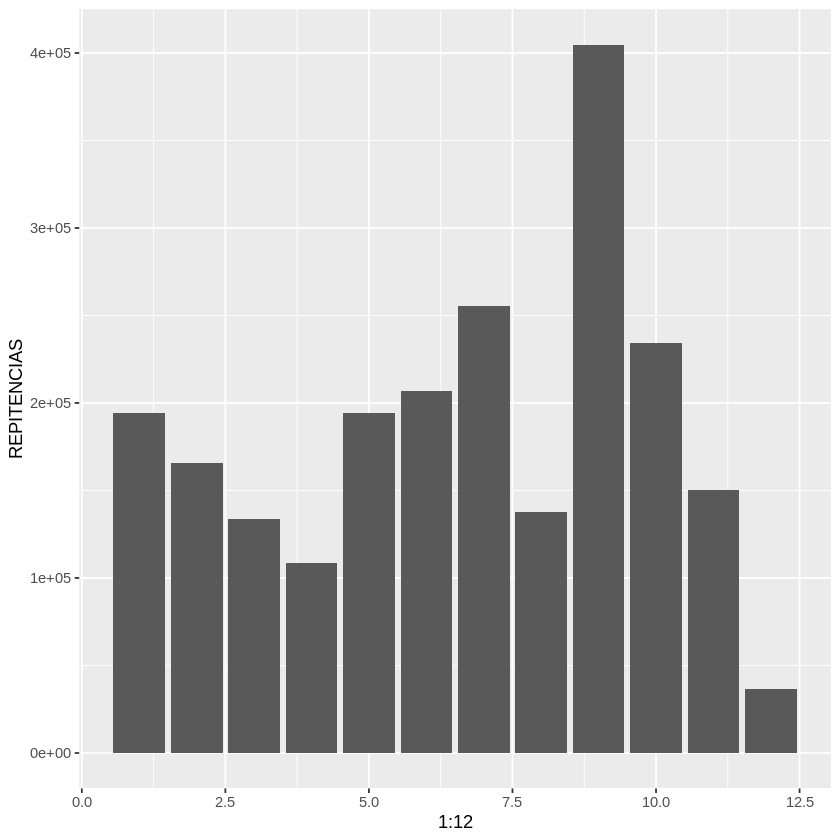

In [ ]:
ggplot(data=resp, aes(x=1:12,y=REPITENCIAS)) + 
    geom_bar(stat="identity", position="stack") 

In [ ]:
dbGetQuery(conn, "
SELECT  MRUN,
        COUNT(AGNO)
FROM alumnos
GROUP BY MRUN;")

In [ ]:
dbGetQuery(conn, "
SELECT  MRUN,
        AVG(PROM_GRAL),
        AVG(ASISTENCIA)
FROM alumnos
GROUP BY MRUN ;")

en los casos donde la cantidad de años aprobados sea mayor que 12

In [52]:
q<- dbSendQuery(conn, "
SELECT  MRUN,
        AVG(PROM_GRAL),
        AVG(ASISTENCIA)
FROM alumnos
GROUP BY MRUN
HAVING COUNT(AGNO)>=12")

In [53]:
d=dbFetch(q,n=10000)

In [54]:
d

MRUN,AVG(PROM_GRAL),AVG(ASISTENCIA)
<int>,<dbl>,<dbl>
NA,4.605891,82.69722
17,5.000000,70.38462
18,4.692308,85.46154
19,5.583333,97.25000
20,3.705882,74.00000
25,3.384615,70.00000
26,5.500000,89.00000
35,5.833333,97.91667
59,4.357143,75.92857


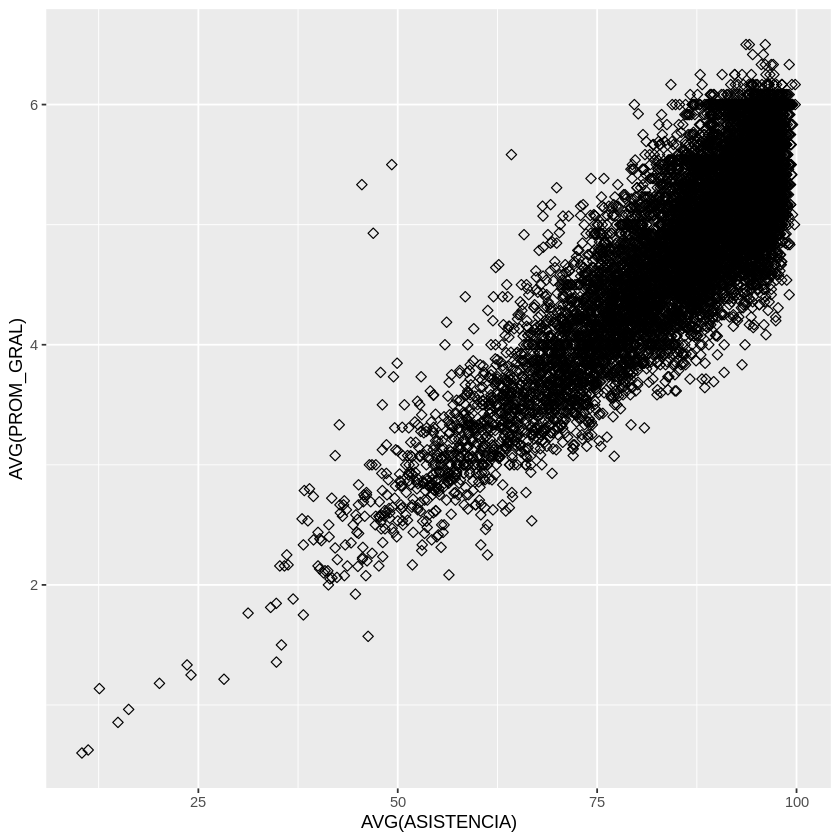

In [55]:
library(ggplot2)
ggplot(d, aes(x=`AVG(ASISTENCIA)`, y=`AVG(PROM_GRAL)`)) +  geom_point(size=2, shape=23)

In [56]:
dbGetQuery(conn, "select * from colegios where RBD==1")



Warning message:
“Closing open result set, pending rows”


RBD,AGNO,NOM_RBD,COD_REG_RBD,NOM_COM_RBD,COD_DEPE,RURAL_RBD
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>
1,2002,LICEO POLITECNICO,1,ARICA,2,0
1,2003,LICEO POLITECNICO,1,ARICA,2,0
1,2004,LICEO POLITECNICO ARICA,1,ARICA,2,0
1,2005,LICEO POLITECNICO ARICA,1,ARICA,2,0
1,2006,LICEO POLITECNICO ARICA,1,ARICA,2,0
1,2007,LICEO POLITECNICO ARICA,15,ARICA,2,0
1,2008,LICEO POLITECNICO ARICA,15,ARICA,2,0
1,2009,LICEO POLITECNICO ARICA,15,ARICA,2,0
1,2010,LICEO POLITECNICO ARICA,15,ARICA,2,0


#Restricciones en SQL

In [36]:
dbListTables(conn)

[1] "alumnos"         "apoderados"      "colegios"        "jardin_infantil"

In [24]:
dbExecute(conn, "DROP TABLE jardin_infantil")


[1] 0

In [26]:
dbExecute(conn, "DROP TABLE apoderados")

[1] 0

In [27]:
dbExecute(conn, "CREATE TABLE jardin_infantil (ID INT PRIMARY KEY, NOMBRE VARCHAR(20) UNIQUE, DIRECCION VARCHAR(20) NOT NULL)")


[1] 0

In [32]:

dbExecute(conn, "CREATE TABLE apoderados (ID INT PRIMARY KEY, NOMBRE VARCHAR(40), TELEFONO VARCHAR(40), ID_ALUMNO INT, CONSTRAINT fk_apoderado_de FOREIGN KEY (ID_ALUMNO) REFERENCES alumnos(MRUN) )")



[1] 0

In [33]:
dbExecute(conn, "PRAGMA foreign_keys = ON;")


[1] 0

In [38]:
dbGetQuery(conn, "PRAGMA table_info(apoderados)")

cid,name,type,notnull,dflt_value,pk
<int>,<chr>,<chr>,<int>,<lgl>,<int>
0,ID,INT,0,NA,1
1,NOMBRE,VARCHAR(40),0,NA,0
2,TELEFONO,VARCHAR(40),0,NA,0
3,ID_ALUMNO,INT,0,NA,0


In [40]:
dbGetQuery(conn,"Select  * from alumnos limit 10")

MRUN,AGNO,RBD,COD_ENSE,COD_GRADO,LET_CUR,GEN_ALU,FEC_NAC_ALU,COD_COM_ALU,SIT_FIN_R,PROM_GRAL,ASISTENCIA
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<int>
10081,2002,1,561,1,A,1,Sep 16 1962,1201,Y,0,0
13604,2002,1,610,3,F,2,Jan 17 1985,1201,P,"5,1",91
20935,2002,1,561,3,A,1,Feb 11 1974,1201,P,6,99
30441,2002,1,510,2,D,1,Jan 2 1986,1201,P,"5,6",97
33767,2002,1,661,4,D,1,Mar 26 1983,1201,P,"6,5",85
37399,2002,1,510,3,G,1,Sep 15 1985,1201,P,"4,9",92
53226,2002,1,510,3,E,1,Dec 10 1985,1201,P,"5,1",86
67099,2002,1,510,1,D,2,May 23 1988,1201,P,"6,5",100
81228,2002,1,510,3,B,1,Apr 12 1985,1201,P,"5,7",99


In [41]:
dbExecute(conn,"INSERT INTO apoderados VALUES (3,'Maria Perez','+56999410013', 10081)")

ERROR: ignored

In [ ]:
dbGetQuery(conn, "UPDATE colegios SET NOM_RBD='ESCUELA PARTICULAR CAICAIEN' where RBD==7321")